# Central Goal of the Project
The main goal of my final project was to collect news text and twitter texts related to foreign policy dispute surrounding installation of THAAD, a missile project which caused foreign policy crisis between South Korea and China on July 8, 2016. 
## Part I
This code is the first part of the project, which again consists of two sections. First is a crawler which collected media publications on China found on Naver, the largest web portal in South Korea. The second code analyzes some dimensions of the collected texts. So far, I have only conducted two analyses. First is a comparison of word counts of news titles published before and after the crisis time point. Second is a comparison of news source outlets before and after the crisis time point. These outputs have some implications on the difference in media publications related to China before and after the crisis time point. 

## Modules
I used the KoNLPy module to tokenize Korean texts. This module includes a open source tokenizer named Open Korean Text which allows tokenizing nouns, phrases, and POS. This module requires Jpype package. Documentations for konlpy is here (http://konlpy.org/en/latest/), for jpype (https://github.com/tcalmant/jpype-py3/).

```
pip3 install konlpy, jpype1, Jpype1-py3
```
OR 
```
git clone https://github.com/tcalmant/jpype-py3.git
cd jpype-py3
python3.7 setup.py install

pip3 install konlpy
```


## Naver Crawler
### Naver News
Parting from my original plan which was to collect all news links found by querying 'China' on Naver, I only collected titles, date of publication, news source, and text of news published on Naver news section for the time frame 2015-01-01 to 2017-07-31, which resulted in 24165 news items. Naver news pages have the same html structure and href pattern (http://news.naver.com) which allowed me to collect the dimensions above. I concluded that this is a better plan because each news outlets have different html structure, and it would be time consuming to collect texts and titles of all of the news that appears as a search result on Naver.

### Contribution
I found many code snippets online that allows crawling Naver news for a query word, but they all had some problems. The biggest problem I found was that although Naver returns a lot of news results, the pagination is limited to 4,000, and this limit is not enough to cover more than one day of news. For instance, news results for one day would lead up to page 4,000. As a result, just relying on pagination and querying does not allow collection of news results across a time frame. To fix this problem, I concatenated the dates and made the function to collect a certain number of pages per day.

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import re
import sys
import time, random


def get_news(n_url):
    """
    Uses request to access url, parse using BeautifulSoup, appends title, date, company
    and text of a given news in the link in a list
    
    Parameters
    ----------
    n_url: a http:// url
    
    Yields
    ------
    list
    """
    news_detail = []
    breq = requests.get(n_url)
    bsoup = BeautifulSoup(breq.content, 'html.parser')
    title = bsoup.select('h3#articleTitle')[0].text
    news_detail.append(title)
    pdate = bsoup.select('.t11')[0].get_text()[:11]
    news_detail.append(pdate)
    _text = bsoup.select('#articleBodyContents')[0].get_text().replace('\n', " ")
    btext = _text.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
    news_detail.append(btext.strip())
    pcompany = bsoup.select('#footer address')[0].a.get_text()
    news_detail.append(pcompany)
    return news_detail

def get_dates():
    """
    Creates a list of dates in string format 'Y-M-D'
    
    Yields
    ------
    list
    
    Note
    ------
    To change collection time frame, mend start_date and end_date
    """
    import datetime
    start_date = datetime.date(2015, 1, 1)
    end_date   = datetime.date(2017, 8, 1)
    date_range_list = []
    date_range = [ start_date + datetime.timedelta(n) for n in range(int ((end_date - start_date).days))]
    for date in date_range:
        date_range_list.append(str(date).replace("-","."))
    return(date_range_list)


def output(query,page,max_page):
    """
    Query a word and return the title, date, company, text of news in dictionary format
    and append all dictionaries in a list
    
    Parameters
    ----------
    query: a string
    page: start page 
    max_page: maximum pages to be crawled per date

    Returns:
    List of dictionaries in a list, with keys title, date, company, text
    """
    news_dicts = []
    # best to concatenate urls here
    date_range = get_dates()
    for date in get_dates():
        start_page = page
        s_date = date.replace(".","")
        while start_page < max_page:
            url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort=0&ds=" + date + "&de=" + date + "&nso=so%3Ar%2Cp%3Afrom" + s_date + "to" + s_date + "%2Ca%3A&start=" + str(start_page)
            header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
            req = requests.get(url,headers=header)
            cont = req.content
            soup = BeautifulSoup(cont, 'html.parser')
            for urls in soup.select("._sp_each_url"):
                try:
                    if urls["href"].startswith("https://news.naver.com"):
                        news_detail = get_news(urls["href"])
                        adict = dict()
                        adict["title"] = news_detail[0]
                        adict["date"] = news_detail[1]
                        adict["company"] = news_detail[3]
                        adict["text"] = news_detail[2]
                        news_dicts.append(adict)
                except Exception as e:
                    continue
            start_page += 10
    return news_dicts

# Query 'China' in Korean
news_dicts = output("중국",1,30)

s_date = "2015.01.01"
e_date = "2017.07.31"
s_from = s_date.replace(".","")
e_to = e_date.replace(".","")

jsonfile = open(s_from+"_news_scrape_"+e_to+".json", 'w')
json.dump(news_dicts, jsonfile)
jsonfile.close()

## Analysis

I conducted some comparison of the news published before and after the crisis time point. First, I retrieved respective word counts for titles published before and after the crisis time point and compared common and different words. Second, I returned a counter for news sources and checked if there is a difference in the news soures that reported on issues related to China before and after the crisis time point.

### Cleaning Text and Using KoNLPy Module to Return Word Counts

Before conducting the analysis, I needed to do several things - first was to convert the dates in the dictionary back to datetime object so that the texts can be called within a time frame. The datetime object was added as a key to the news item dictionary. Second was to make titles or text into one string so that the words can be counted regarding the entire set of titles or text during a specific period. The last step was to canonicalize the text by removing punctuations, digits, and alphabets, and using Okt(), a Open Korean Text class, a tokenizer package for Korean text in the KoNLPy module. 

In [1]:
# Import JSON Collected Using Naver Crawler
import json
filename = '20150101_news_scrape_20170731.json'
with open(filename) as json_data:
    dt = json.load(json_data)

# Make Date Comparable
def ConvertDates(string_date):
    '''
    Convert string dates ("Y-M-D") to datetime object
    
    Parameters
    ----------
    string_date: a string
    
    Returns
    -------
    datetime object
    '''
    import datetime
    string_date = string_date.replace("-","")
    string_date = string_date.strip()
    date = datetime.datetime.strptime(string_date,"%Y%m%d").date()
    return date

# Add Converted Date as Key
def ChangeDicts(data):
    import datetime
    for d in data:
        d['date_conv'] = ConvertDates(d['date'])
    # update key
    return data

# Create String Before Conducting Word Count
def PreCorpus(data,key,s_date,e_date):
    """
    String join all text under time condition

    Parameters
    ----------
    data : a list of dictionaries
    key: the key in the dictionary within the list
    s_date: start date, in string "Y-M-D"
    e_date: end date, in string "Y-M-D"

    Returns
    -------
    a string
    """
    data = ChangeDicts(data)
    text_list = []
    for d in data:
        if (d['date_conv'] >= ConvertDates(s_date)) & (d['date_conv'] <= ConvertDates(e_date)):
            text_list.append(d[key])
    all_text = ' '.join(text_list)
    return all_text

class NaverNewsCorpus:
    '''
    Functions
    ---------
    __init__: returns a string to be cleaned
    text_cleaning: returns a list of characters  
    getPreWordCorpus: join the results of text_cleaning
    getWordCorpus: returns a string 
    getWordCounts: returns a word count dictionary
    '''
    def __init__(self, text):
        self.text = text
    def text_cleaning(self):
        import re
        result_list = []
        for item in self.text:
            cleaned_text = re.sub('[a-zA-Z]', '', item)
            cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"...]',
                              '', cleaned_text)
            result_list.append(cleaned_text)
        return result_list
    def getPreWordCorpus(self):
        result=self.text_cleaning()
        doc = (''.join(result))
        return doc
    def getWordCorpus(self):
        doc = self.getPreWordCorpus()
        text = ''.join(c for c in doc if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
    def getWordCounts(self,k):
        from konlpy.tag import Okt
        from collections import Counter
        nouns_tagger = Okt()
        word_corpus = self.getWordCorpus()
        nouns = nouns_tagger.nouns(word_corpus)
        count = Counter(nouns)
        view_count = count.most_common(k)
        return dict(view_count)

# Counts News Sources
def NewsSourceCounter(data,n,s_date,e_date):
    '''
    Parameters
    ----------
    data: list of dictionaries
    n: number of most common word counts 
    s_date: start date of news publication
    e_date: end date of news publication
    
    Returns
    -------
    a dictionary
    '''
    from collections import Counter
    company_list = []
    for d in data:
        if (d['date_conv'] >= ConvertDates(s_date)) & (d['date_conv'] <= ConvertDates(e_date)):
            company_list.append(d['company'])
    count = Counter(company_list)
    view_counts = count.most_common(n)
    return dict(view_counts)


# Output as Word Counts
def output(data,key,s_date,e_date,n):
    """
    Parameters
    ----------
    data: list of dictionaries
    key: the key to retrieve text from (either "title" or "text")
    s_date: start date of news publication
    e_date: end date of news publication\
    
    Returns
    -------
    a dictionary
    
    """
    text_corpus = PreCorpus(data,key,s_date,e_date)
    corpus = NaverNewsCorpus(text_corpus)
    return corpus.getWordCounts(n)


### Analyses

The functions below include a function that returns common words between two sets of word count dictionaries for two periods, and a function that returns different words. 

In [2]:
# Get Common Words in Respective Word Count Results

def GetCommonWords(first,second):
    '''
    Compare two word count dictionaries and return overlapping words
    Create keys: word, count, year
    
    Parameters
    ----------
    first: a word count dictionary
    second: a word count dictionary
    
    Returns
    -------
    a panda data frame
    '''
    import pandas as pd
    common_keys = list(set(first).intersection(set(second)))
    first_new = {}
    second_new = {}
    for k,v in first.items():
        if k in common_keys:
            first_new[k] = v
    for k,v in second.items():
        if k in common_keys:
            second_new[k] = v
    CommonWordsDf = pd.DataFrame({'pre-crisis':pd.Series(first_new),'post_crisis':pd.Series(second_new)})
    return CommonWordsDf


def GetCounterDifference(first,second):
    '''
    Compare two word count dictionaries and return the difference
    From second dictionary, subtract the overlapping keys from the first dictionary, and return the remainder
    key and values of the second dictionary
    
    Parameters
    ---------
    first: a word count dictionary
    second: a word count dictionary
    
    Returns
    ------
    a panda data frame
    '''
    import pandas as pd
    first_keys = list(set(first))
    second_keys = list(set(second))
    counts_difference = list(set(second_keys) - set(first_keys))
    new = {}
    for k,v in second.items():
        if k in counts_difference:
            new[k] = v
    ContrastWordsDf = pd.DataFrame.from_dict(new, orient='index',columns = ['word_count'])
    return ContrastWordsDf

## Results

I compared news titles published between 2015-07-31 and 2016-07-07, and titles published between 2016-07-08 to 2017-07-31. These two periods are split on July 8, 2016, which marks the crisis time point.

In [3]:
word_first = output(dt,'title','2015-07-31','2016-07-07',100)
word_second = output(dt,'title','2016-07-08','2017-07-31',100)

news_first = NewsSourceCounter(dt,30,'2015-07-31','2016-07-07')
news_second = NewsSourceCounter(dt,30,'2016-07-08','2017-07-31')

In [4]:
# Dictionaries to Pandas

import pandas as pd
pre_crisisDf = pd.DataFrame.from_dict(word_first, orient='index',columns = ['word_count'])
post_crisisDf = pd.DataFrame.from_dict(word_second, orient='index',columns = ['word_count'])

# Common Words Df:
CommonWordsDf = GetCommonWords(word_first,word_second)

# Contrast Words Df:
ContrastWordsDf = GetCounterDifference(word_first,word_second)

### Common Frequent Words in News Titles Between Pre-Crisis and Post-Crisis Period

To compare the frequency of common words in the news titles, I compared the top 7 to 55 words in the dictionaries returned. I skipped the first six because they were expected words, such as China, Chinese, and North Korea.

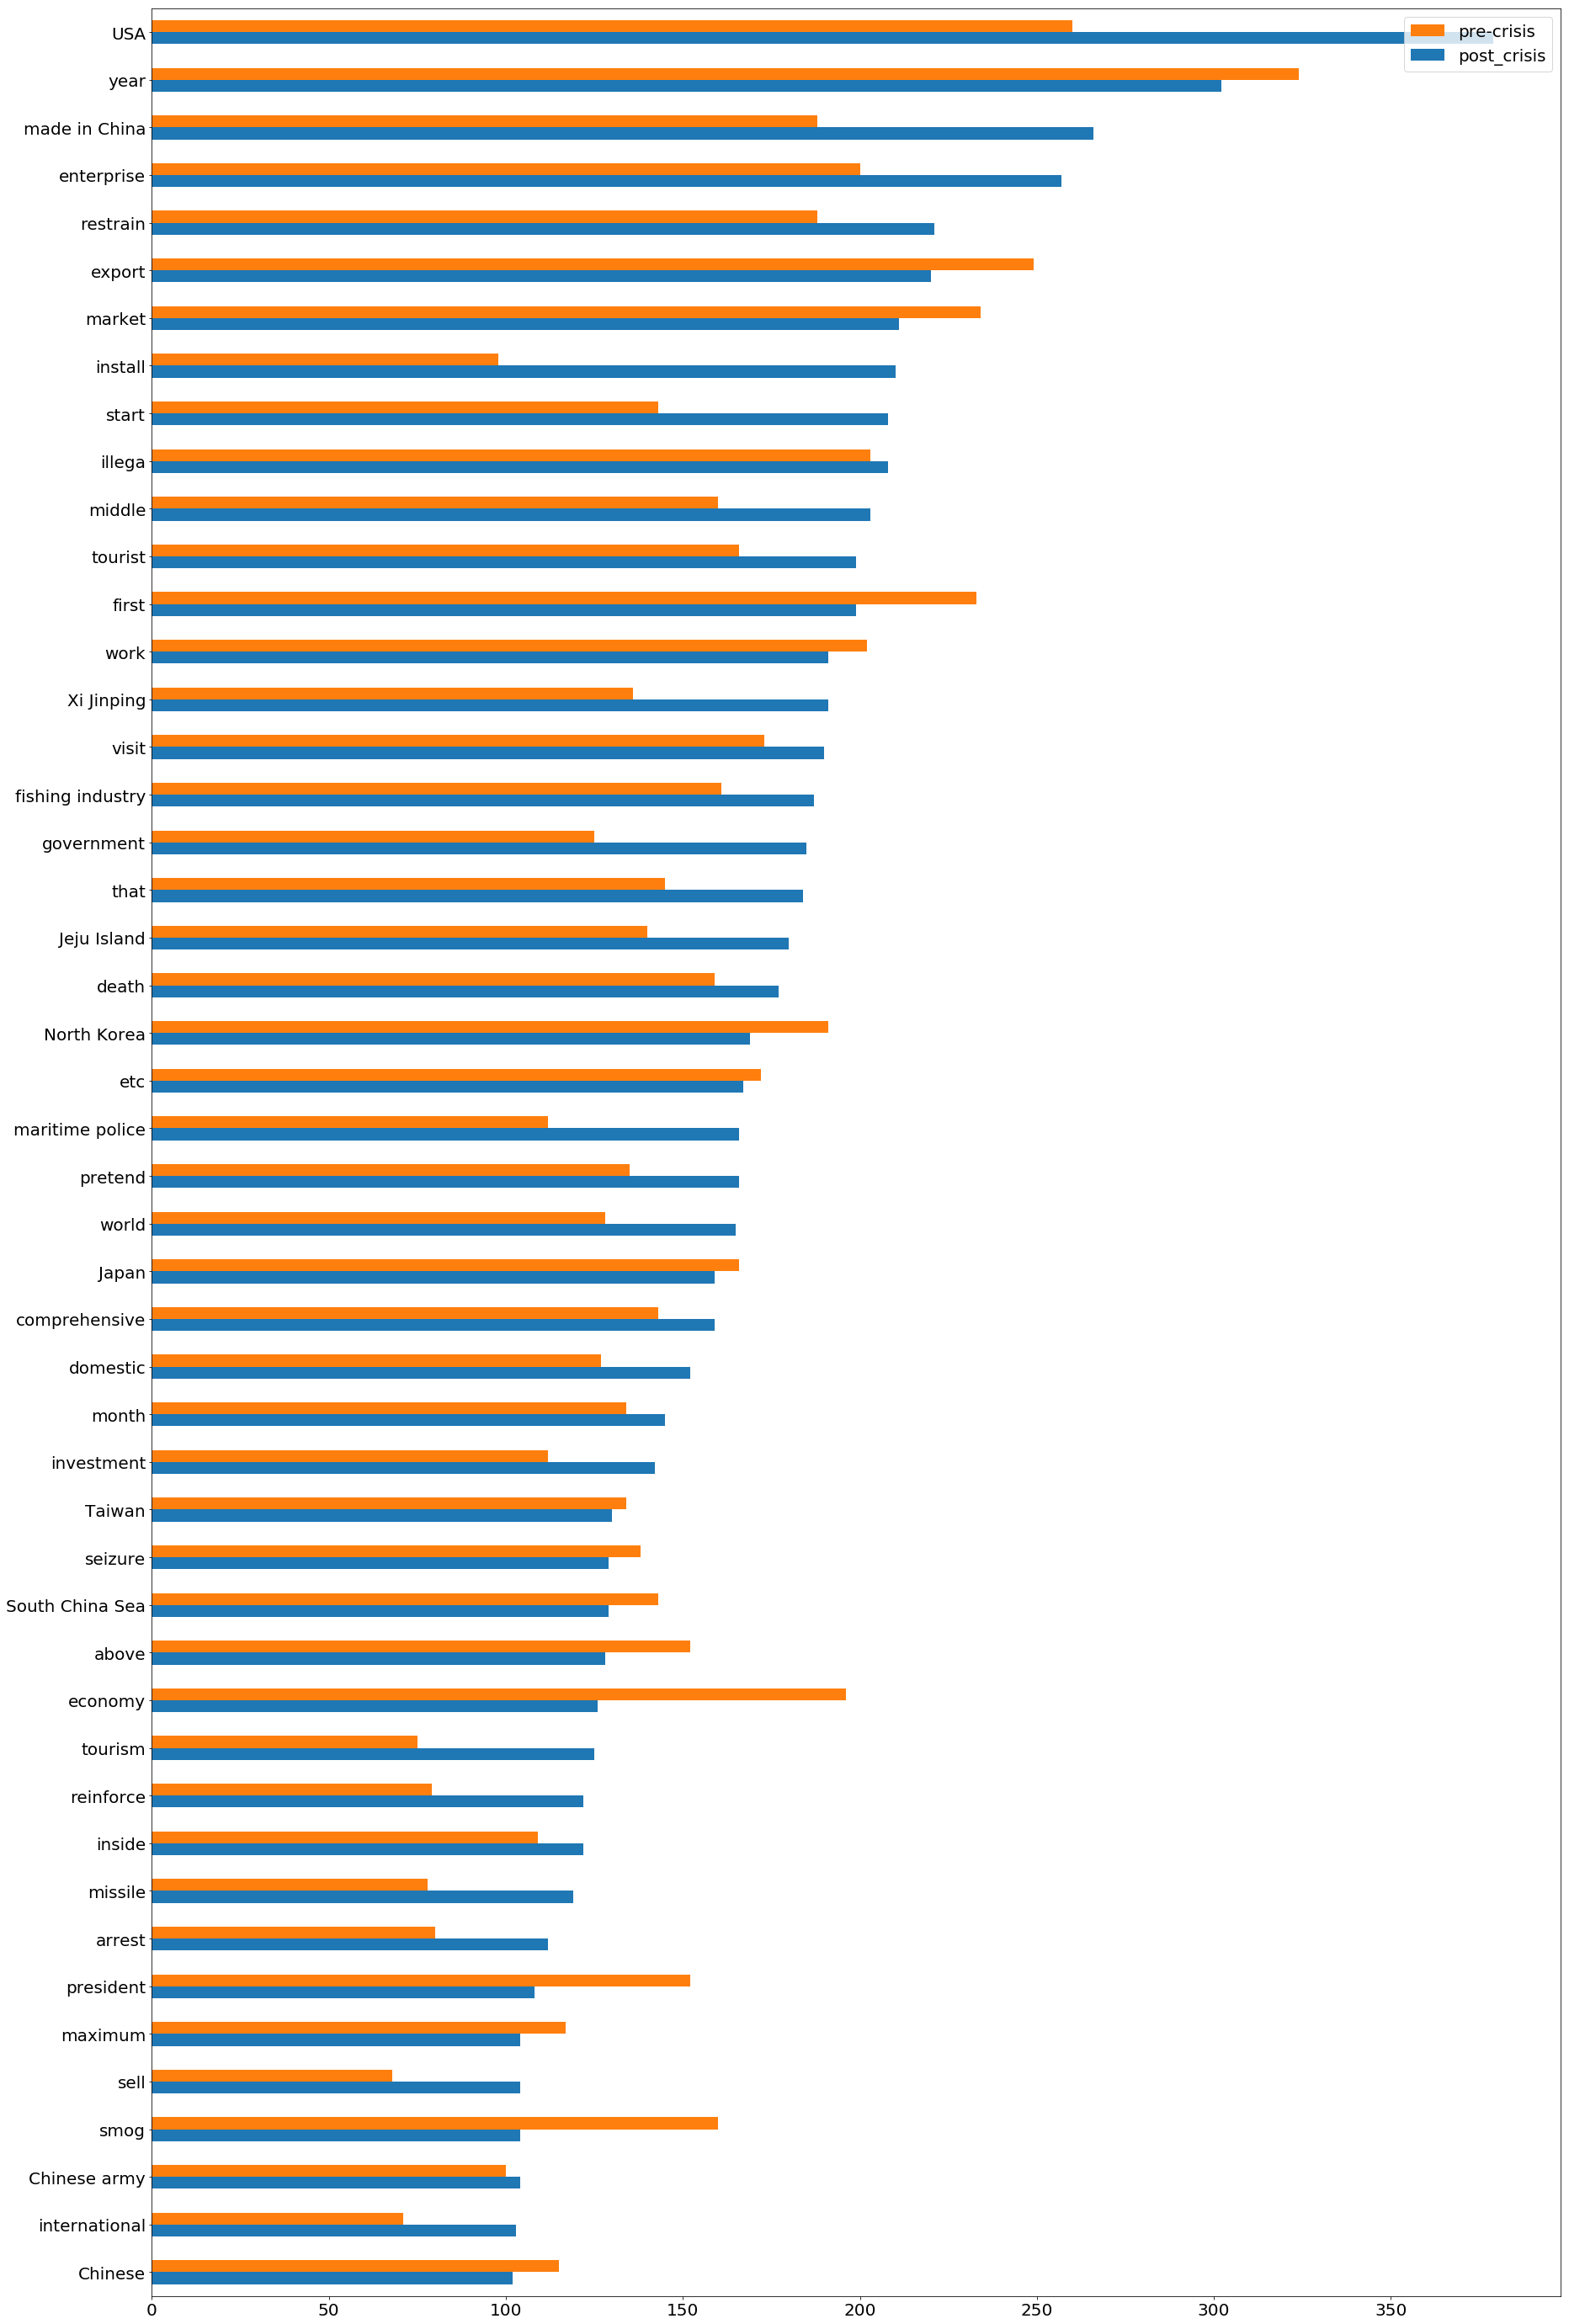

In [8]:
CommonWordsDf = CommonWordsDf.sort_values(['post_crisis'], ascending = False)

subset = CommonWordsDf.iloc[7:55].copy()

eng = {'미국':'USA', '년':'year', '중국산':'made in China', '기업':'enterprise', '제재':'restrain', '수출':'export', '시장':'market', '배치':'install', '불법':'illega', '발':'start', '중':'middle', '첫':'first',
       '관광객':'tourist', '시진핑':'Xi Jinping', '일':'work', '방문':'visit', '조업':'fishing industry', '정부':'government', '것':'that', '제주':'Jeju Island', '사망':'death', '대북':'North Korea', '등':'etc', '척':'pretend',
       '해경':'maritime police', '세계':'world', '일본':'Japan', '종합':'comprehensive', '국내':'domestic', '월':'month', '투자':'investment', '대만':'Taiwan', '남중국해':'South China Sea', '나포':'seizure', '위':'above', '경제':'economy',
       '관광':'tourism','내':'inside','강화':'reinforce', '미사일':'missile', '검거':'arrest', '대통령':'president', '중국군':'Chinese army','스모그':'smog', '최대':'maximum','판매':'sell','국제':'international',
       '중국어':'Chinese'}
subset.rename(columns = {'pre_crisis':'pre_crisis','post_crisis':'post_crisis'}, index = eng, inplace=True)
mplot = subset[subset.columns[::-1]].sort_values(['post_crisis'], ascending = True).plot.barh(figsize=(30,50),fontsize=20)

handles, labels = mplot.get_legend_handles_labels()
mplot.legend(handles[::-1], labels[::-1],fontsize = 20, loc='upper right')


### Contrasting Frequent Words in News Titles Between Pre-Crisis and Post-Crisis Period

The graph below returns a plot of frequent words in the headlines of news items in the post-crisis period which are NOT in the pre-crisis period titles.

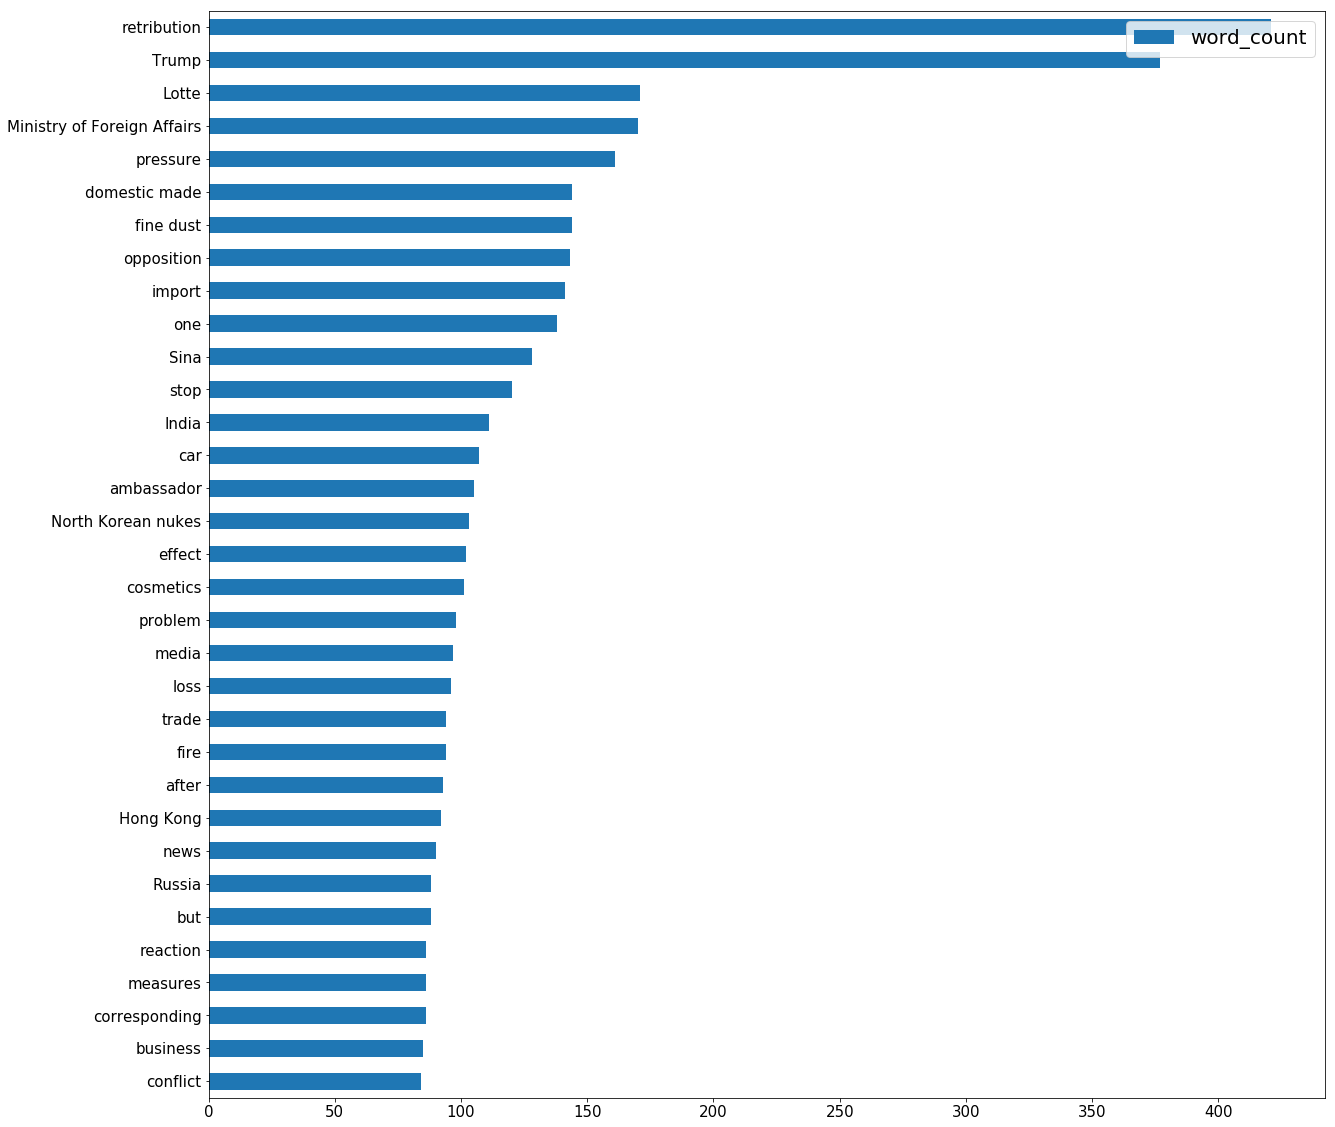

In [9]:
eng = {'보복':'retribution', '트럼프':'Trump', '롯데':'Lotte', '외교부':'Ministry of Foreign Affairs', '압박':'pressure', '국산':'domestic made', '미세먼지':'fine dust', '반대':'opposition', '수입':'import', '하나':'one', '차이나':'Sina',
       '관광':'tourism', '강화':'reinforce', '중단':'stop', '미사일':'missile', '검거':'arrest', '인도':'India', '차':'car', '대사':'ambassador', '판매':'sell', '국제':'international', '북핵':'North Korean nukes','영향':'effect', '화장품':'cosmetics', '문제':'problem', '매체':'media', '피해':'loss', '무역':'trade', '발사':'fire',
       '후':'after', '홍콩':'Hong Kong', '뉴스':'news', '러시아':'Russia', '단':'but', '반발':'reaction', '조치':'measures', '대응':'corresponding', '업체':'business', '갈등':'conflict'}
ContrastWordsDf.rename(columns = {'word_count':'word_count'},index=eng,inplace=True)
cplot = ContrastWordsDf.sort_values(['word_count'], ascending = True).plot.barh(figsize=(20,20),fontsize = 15)
cplot.legend(fontsize = 20, loc='upper right')

#### Counts of Words 'fine dust', 'India' and 'Hong Kong'

These three words are not directly related to the crisis, yet are included in the top 100 frequent words during the post-crisis period. To understand the frequency of these words for both periods, next I return a graph comparing the counts of these words in the pre and post-crisis period.

In [10]:
# Return More Outputs for the Pre-Crisis Period
word_first_large = output(dt,'title','2015-07-31','2016-07-07',200)

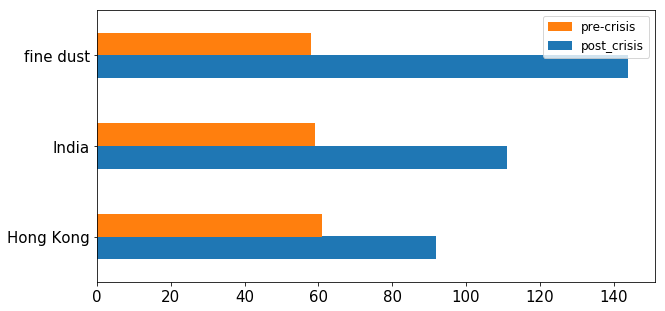

In [11]:
# Visualize Pre and Post Crisis Period For the Selected Words

# Get pre-crisis data frame 
pre_crisisDf = pd.DataFrame.from_dict(word_first_large, orient='index',columns = ['word_count'])

# Define words to get counts from
e_word_list = ['fine dust','India','Hong Kong']
k_word_list = ['미세먼지','인도','홍콩']

def append_values(df, alist):
    d = {}
    for word in alist:
        d[word] = df.loc[word,'word_count']
    return d

post_wc = append_values(ContrastWordsDf,e_word_list)
pre_wc = append_values(pre_crisisDf,k_word_list)

pre_e_wc = dict(zip(e_word_list,list(pre_wc.values())))

# Create new data frame
new_df = pd.DataFrame({'post_crisis':pd.Series(post_wc),'pre-crisis':pd.Series(pre_e_wc)})

# Plot
zplot = new_df.sort_values(['post_crisis'], ascending = True).plot.barh(figsize=(10,5),fontsize=15)
handles, labels = zplot.get_legend_handles_labels()
zplot.legend(handles[::-1], labels[::-1],fontsize = 12, loc='upper right')

### News Source Counter Difference

Below returns a graph comparing top 30 news sources which reported on China during the pre and post-crisis period.

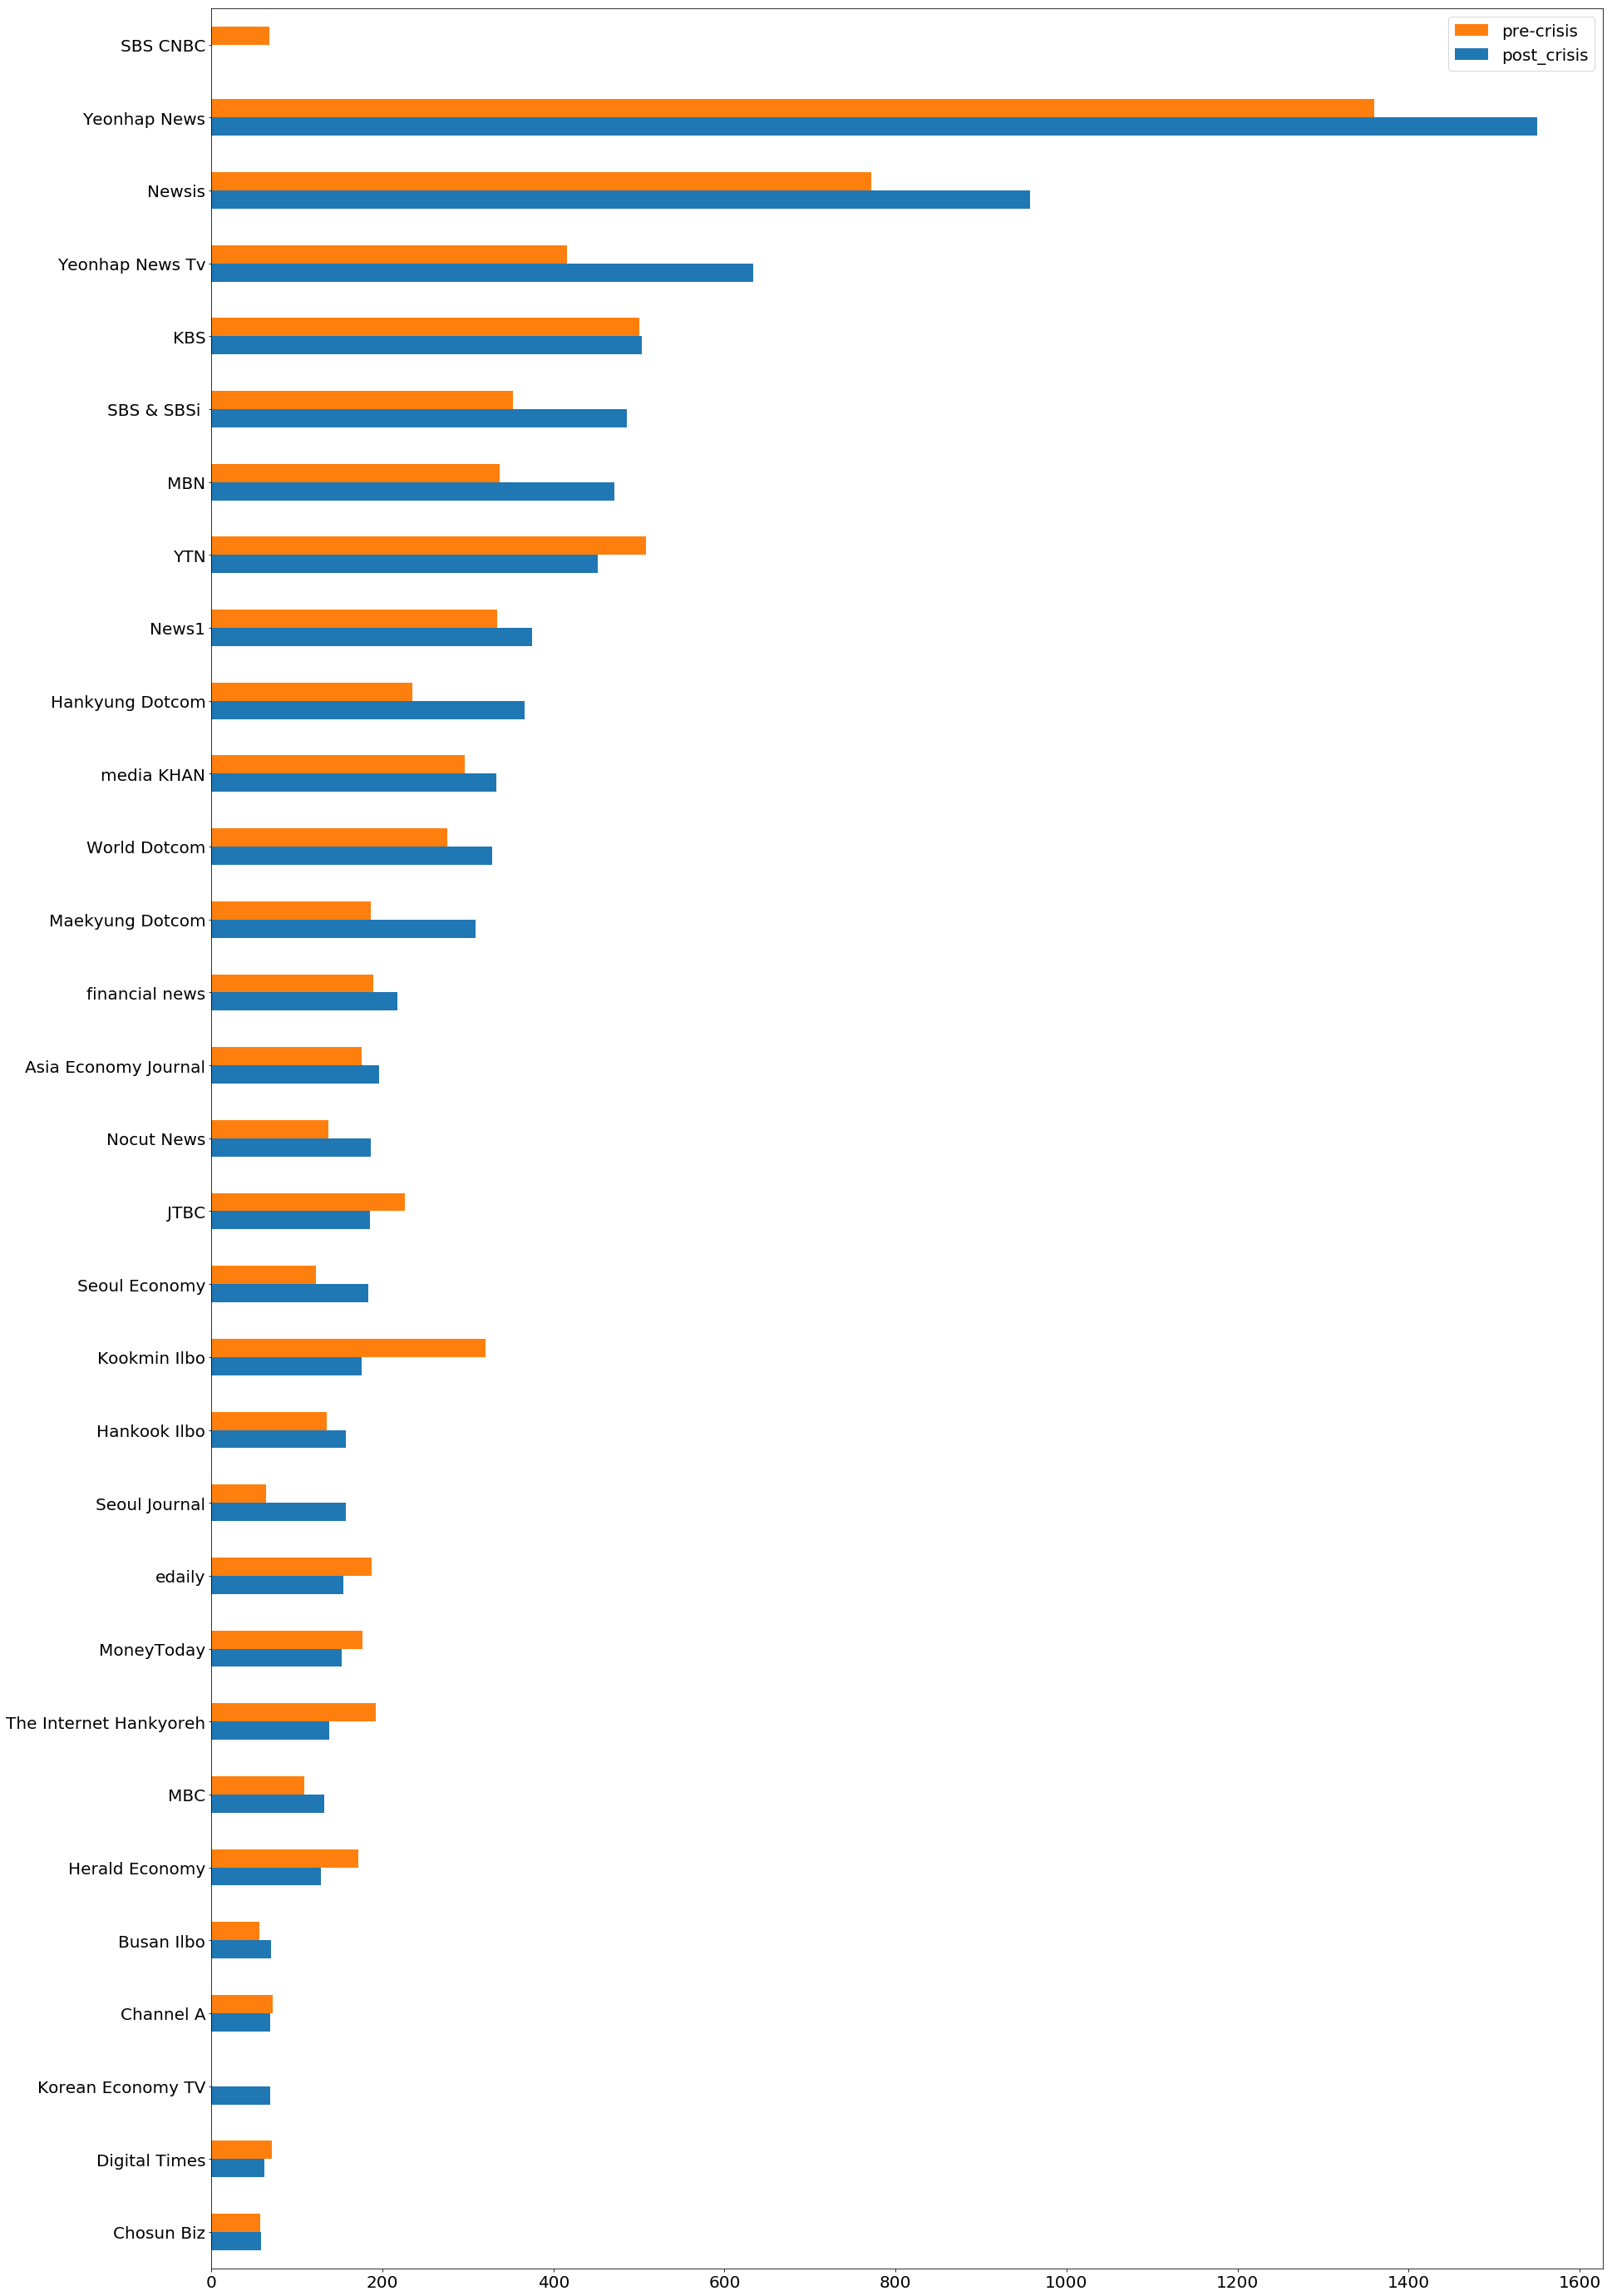

In [12]:
news_all = pd.DataFrame({'pre-crisis':pd.Series(news_first),'post_crisis':pd.Series(news_second)})
news_all.index
eng = {'JTBC':'JTBC', 'KBS':'KBS', 'MBC':'MBC', 'MBN':'MBN', 'MoneyToday':'MoneyToday', 'SBS & SBSi ':'SBS & SBSi ', 'SBS CNBC':'SBS CNBC','The Internet Hankyoreh':'The Internet Hankyoreh', 'YTN':'YTN', 'edaily':'edaily', 'financial news':'financial news',
       'media KHAN':'media KHAN', '국민일보':'Kookmin Ilbo', '노컷뉴스':'Nocut News', '뉴스1':'News1', '뉴시스':'Newsis', '디지털타임스':'Digital Times', '매경닷컴':'Maekyung Dotcom', '부산일보':'Busan Ilbo',
       '서울경제':'Seoul Economy', '서울신문':'Seoul Journal', '세계닷컴':'World Dotcom', '아시아경제신문':'Asia Economy Journal', '연합뉴스':'Yeonhap News', '연합뉴스TV':'Yeonhap News Tv', '조선비즈':'Chosun Biz', '채널A':'Channel A',
       '한경닷컴':'Hankyung Dotcom', '한국경제TV':'Korean Economy TV', '한국일보':'Hankook Ilbo', '헤럴드경제':'Herald Economy'}
news_all.rename(columns = {'pre-crisis':'pre-crisis','post-crisis':'post-crisis'},index=eng,inplace=True)

fplot = news_all[news_all.columns[::-1]].sort_values(['post_crisis'], ascending = True).plot.barh(figsize=(30,50),fontsize=20)

handles, labels = fplot.get_legend_handles_labels()
fplot.legend(handles[::-1], labels[::-1],fontsize = 20, loc='upper right')

## What the Results May Imply
### Common Words
There was some difference in the distribution of common words in the pre-crisis and post-crisis period. Words such as ‘USA’, ‘install’, ‘Xi Jinping’, ’government’, ‘tourism’, ’missile’ appeared more in the news titles compared to the pre-crisis period. This not too surprising, given its connection with the THAAD crisis.

However, it is noticeable that ‘smog’ appeared more frequently in headlines during the pre-crisis period, compared to the post-crisis period. This finding was unexpected because I previously thought that smog would be more referenced during the post-crisis period, due to its negative connotations towards China.

### Different Words
Most of the words were related to the crisis. For instance, words such as retribution, Lotte, tourism, car are connected to retaliatory policies China initiated against South Korean market and industry, which involved shutting down Korean manufacturing car companies and setting limits on Chinese tourists traveling to South Korea.

However, there are some words unrelated to THAAD, which are fine dust, India, and Hong Kong. The following graph shows that there were more news titles mentioning these three words during the post-crisis period compared to the pre-crisis period. I particularly find that fine dust is interesting because it is associated with pollution. The fact that ‘smog’ appears more during the pre-crisis period, but ‘fine dust’ appears less compared to the post-crisis period could imply that there has been a change in how the media relates China and environmental pollution – ‘fine dust’ has a more direct relationship with health compared to smog, which may increase negative sentiment towards China in general. However, this remains at best a speculation, so the next steps in this project would require a more qualitative understanding of news titles including the word ‘fine dust’, as well as other two words during the pre and post-crisis period.

### News Source

Newsis reported slightly more on China during the post-crisis period compared to the pre-crisis period, but the difference does not seem significant. I can't find a significant difference in the frequency of reports during the pre and post-crisis period for the respective news companies.

## Next Steps
The data analyses implies that word counts difference on the three words 'fine dust','Hong Kong' and 'India' requires further examination. I plan to examine news samples including these key words in the titles to get sense of the difference in content between pre and post-crisis period.